# Auxiliando os Times de Marketing e Pricing da Empresa de Delivery

A gente trabalha em uma empresa de delivery, num time de dados centralizado que atende a diversas áreas e recebemos algumas demandas que serão respondidas por meio da Análise dos dados.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import df2img

Numa ação de marketing, para atrair mais entregadores, vamos dar uma bonificação para os 20 entregadores que possuem maior distância percorrida ao todo. A bonificação vai variar de acordo com o tipo de profissional que ele é e o modelo que ele usa para se locomover (moto, bike, etc). Levante essas informações.

In [2]:
# Lendo os dados em formato ".csv".
drivers = pd.read_csv('./data/drivers.csv')
deliveries = pd.read_csv('./data/deliveries.csv')
orders = pd.read_csv('./data/orders.csv')
stores = pd.read_csv('./data/stores.csv')
hubs = pd.read_csv('./data/hubs.csv')
payments = pd.read_csv('./data/payments.csv')

In [3]:
# Filtrando somente as entregas realizadas.
deliveries = deliveries[deliveries['delivery_status'] == 'DELIVERED']

# Excluindo linhas com ids não informados.
deliveries = deliveries.dropna(subset=['driver_id'])

# Modificando os ids para ser do tipo int.
deliveries['driver_id'] = deliveries['driver_id'].astype(int)

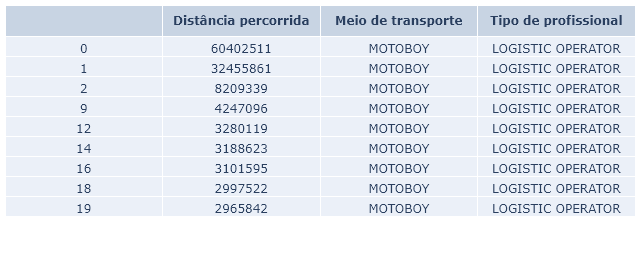

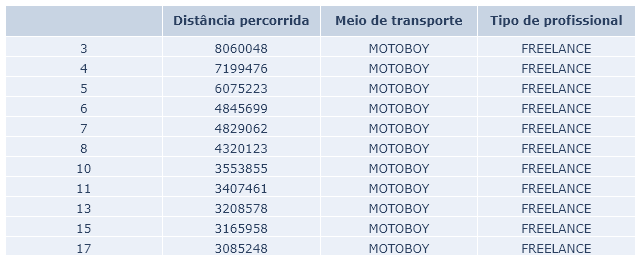

In [95]:
# Filtrando os 20 entregadores com maior distância percorrida.
top20 = deliveries.groupby('driver_id')['delivery_distance_meters'].sum().sort_values(ascending=False).head(20)

# Juntando a tabela dos 20 entregadores com maior distância e suas informações de meio de transporte e tipo.
top20_infos = pd.merge(top20, drivers, on='driver_id').drop('driver_id', axis = 1)

# Foi possível ver que o meio de transporte de todos os 20 entregadores é a moto.
# Então basta separar pelos dois tipos de entregadores.
tops_operator = top20_infos[top20_infos['driver_type'] == 'LOGISTIC OPERATOR']
tops_freelance = top20_infos[top20_infos['driver_type'] == 'FREELANCE']

# Exportando tabelas
dataframes = [tops_operator, tops_freelance]
filenames = ['tops_operator', 'tops_freelance']

for i in range(len(filenames)):
  dataframes[i].columns = ['Distância percorrida', 'Meio de transporte', 'Tipo de profissional']
  img = df2img.plot_dataframe(dataframes[i], fig_size=(640,260))
  df2img.save_dataframe(img, filename=f"./output/{filenames[i]}.png")

Além disso, o time de Pricing precisa ajustar os valores pagos aos entregadores. Para isso, eles precisam da distância média percorrida pelos entregadores separada por estado, já que cada região terá seu preço.

In [7]:
# Selecionando o estado de cada loja pelo estado do hub_id vinculado a ela.
hubs_stores = pd.merge(hubs[['hub_id', 'hub_state']], stores[['store_id', 'hub_id', 'store_segment']], on='hub_id')

# Selecionando o identificador da entrega relacionada com o pedido e mantendo sempre o estado.
stores_orders = pd.merge(hubs_stores[['store_id', 'hub_state', 'store_segment']], orders[['store_id', 'delivery_order_id', 'order_status', 'payment_order_id']], on='store_id')

# Filtrando apenas as que o status do pedido estiver concluído.
stores_orders = stores_orders[stores_orders['order_status'] == 'FINISHED']

# Juntando o estado com os dados de id e distância de entregadores.
orders_delivery = pd.merge(stores_orders[['delivery_order_id', 'hub_state']], deliveries[['delivery_order_id', 'driver_id', 'delivery_distance_meters']], on='delivery_order_id')

# Tirando a coluna "delivery_order_id" que não é mais necessária.
orders_delivery = orders_delivery.drop('delivery_order_id', axis=1)

# Distância percorrida por cada entregador.
distancia_entregador = orders_delivery.groupby(['hub_state', 'driver_id'])['delivery_distance_meters'].mean().reset_index()

# Distância média percorrida pelos entregadores separada por estado.
dados_estado = distancia_entregador.groupby('hub_state')['delivery_distance_meters'].mean().reset_index()

# Ordenando do maior para o menor
dados_estado = dados_estado.sort_values(by='delivery_distance_meters', ascending=False)

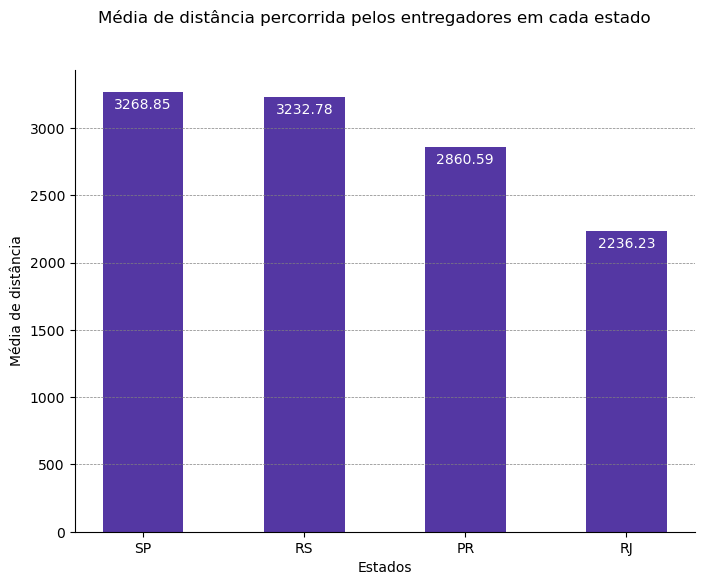

In [8]:
# Criando gráfico
fig, ax = plt.subplots(figsize=(8, 6))

# Definindo gráfico do tipo barra e quais colunas serão usadas.
bars = ax.bar(dados_estado['hub_state'], dados_estado['delivery_distance_meters'], width=0.5, color='#5437a3')

# Colocando título superior.
fig.suptitle('Média de distância percorrida pelos entregadores em cada estado')

# Colocando label para o eixo x e y.
plt.xlabel('Estados')
plt.ylabel('Média de distância')

# Adicionando valores sobre cada barra
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height - 150, f'{height:.2f}', 
            ha='center', va='bottom', fontsize=10, color='white')

# Colocando grid apenas no eixo y
ax.yaxis.grid(True, linestyle='--', color='gray', linewidth=0.5)
ax.xaxis.grid(False)

# Removendo bordas do gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Salvando gráfico.
plt.savefig('./output/media_estado', bbox_inches='tight')

Por fim, o CFO precisa de alguns indicadores de receita para apresentar para a diretoria executiva. Dentre esses indicadores, vocês precisarão levantar (1) a receita média e total separada por tipo (Food x Good), (2) A receita média e total por estado.

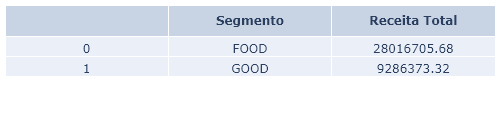

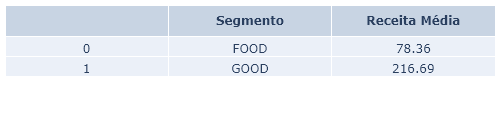

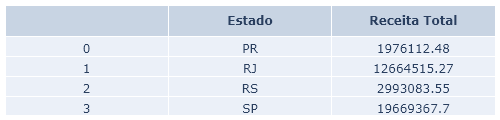

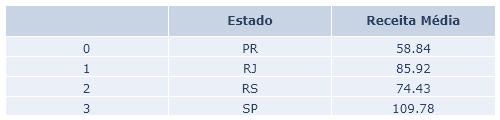

In [76]:
# Construindo tabela com as informações necessárias.
store_orders_payments = pd.merge(stores_orders[['payment_order_id', 'store_segment', 'hub_state']], payments[['payment_order_id', 'payment_amount', 'payment_status']], on='payment_order_id')

# Filtrando pagamentos concluídos.
store_orders_payments = store_orders_payments[store_orders_payments['payment_status'] == 'PAID']

# Receita total do tipo Food e Good.
receita_total_tipo = store_orders_payments.groupby('store_segment')['payment_amount'].sum().reset_index()
receita_total_tipo.columns = ['Segmento', 'Receita Total']

# Receita média do tipo Food e Good.
receita_media_tipo = store_orders_payments.groupby('store_segment')['payment_amount'].mean().reset_index().round(2)
receita_media_tipo.columns = ['Segmento', 'Receita Média']

# Receita média por estado.
receita_total_estado = store_orders_payments.groupby('hub_state')['payment_amount'].sum().reset_index()
receita_total_estado.columns = ['Estado', 'Receita Total']

# Receita total por estado.
receita_media_estado = store_orders_payments.groupby('hub_state')['payment_amount'].mean().reset_index().round(2)
receita_media_estado.columns = ['Estado', 'Receita Média']

# Exportando tabelas.
dataframes = [receita_total_tipo, receita_media_tipo, receita_total_estado, receita_media_estado]
filenames = ['receita_total_tipo', 'receita_media_tipo', 'receita_total_estado', 'receita_media_estado']

for i in range(len(filenames)):
  img = df2img.plot_dataframe(dataframes[i], fig_size=(500,120))
  df2img.save_dataframe(img, filename=f"./output/{filenames[i]}.png")

Se a empresa tem um gasto fixo de 5 reais por entrega, recebe 15% do valor de cada entrega como receita e, do total do lucro, distribui 20% em forma de bônus para os 2 mil funcionários, quanto cada um irá receber no período contido no dataset?